The script provides the code for the paper of co-crystal discovery and is separated into the following parts:


1. Importing the datasets from CSD and ZINC 15 (all the features are implemented and no feature engineering is required).
2. A deep neural network for one class classification was built using Pytorch library. The deepSVDD architecture was adapted from '**Deep One-Class Classification**, Ruff et al,Proceedings of the 35th International Conference on Machine Learning, 393-4402, 2018,80. The Attention-based autoencoder implemented was adapted from '**Set Transformer: A Framework for Attention-based Permutation-Invariant Neural Networks**, Lee et al, Proceedings of the 36th International Conference on Machine Learning, 3744-3753,2019.
3. The evaluation of the network is performed with k-fold cross validation on measuring the True Positive Rate.
4. The trained model is used for scoring the labeled and unlabeled data.
5. The molecular pairs are visualized.



# Import the relevant datasets

In [ ]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the scaled datasets

# Labelled dataset
df = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/labelled_scaled.csv')
labelled = df.iloc[:1722 , 1:]

# Unlabelled dataset
uf_final= pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_scaled.csv')
uf= uf_final.iloc[:, 1:]
uf.head()

,MW_1,AMW_1,Sv_1,Se_1,Sp_1,Si_1,Mv_1,Me_1,Mp_1,Mi_1,nAT_1,nSK_1,nBT_1,nBO_1,nBM_1,SCBO_1,RBN_1,RBF_1,nDB_1,nTB_1,nAB_1,nH_1,nC_1,nN_1,nO_1,nP_1,nS_1,nF_1,nCL_1,nBR_1,nHM_1,nHet_1,nX_1,H%_1,C%_1,N%_1,O%_1,X%_1,nCsp3_1,nCsp2_1,...,Ui_2,Hy_2,AMR_2,TPSA(NO)_2,TPSA(Tot)_2,MLOGP_2,MLOGP2_2,ALOGP_2,ALOGP2_2,SAtot_2,SAacc_2,Vx_2,VvdwMG_2,VvdwZAZ_2,PDI_2,BLTF96_2,BLTD48_2,BLTA96_2,cRo5_2,DLS_01_2,DLS_02_2,DLS_03_2,DLS_04_2,DLS_05_2,DLS_06_2,DLS_cons_2,LLS_01_2,LLS_02_2,CMC-80_2,CMC-50_2,Inflammat-80_2,Inflammat-50_2,Depressant-80_2,Psychotic-80_2,Hypertens-80_2,Hypnotic-80_2,Neoplastic-80_2,Neoplastic-50_2,Infective-80_2,Infective-50_2
0,0.058642,0.12109,0.05542,0.042732,0.050129,0.040501,0.464348,0.333333,0.26408,0.27881,0.042781,0.069519,0.051151,0.073733,0.086207,0.083882,0.0,0.0,0.25,0.0,0.063218,0.038095,0.073684,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.44,0.802343,0.0,0.179487,0.0,0.0,0.102564,...,0.555039,0.004827,0.066521,0.0,0.0,0.552491,0.048765,0.145094,0.005797,0.032926,0.0,0.055125,0.055125,0.037961,0.675758,0.627380,0.627174,0.627539,1.0,0.666667,0.397590,0.746269,0.2,0.0,0.795181,0.517647,0.795181,0.506667,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.058642,0.12109,0.05542,0.042732,0.050129,0.040501,0.464348,0.333333,0.26408,0.27881,0.042781,0.069519,0.051151,0.073733,0.086207,0.083882,0.0,0.0,0.25,0.0,0.063218,0.038095,0.073684,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.44,0.802343,0.0,0.179487,0.0,0.0,0.102564,...,0.572844,0.004259,0.077234,0.0,0.0,0.561970,0.056324,0.155222,0.007583,0.045239,0.0,0.067175,0.067174,0.049438,0.609091,0.614014,0.614130,0.614114,1.0,0.666667,0.397590,0.746269,0.2,0.0,0.795181,0.517647,0.795181,0.506667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.058642,0.12109,0.05542,0.042732,0.050129,0.040501,0.464348,0.333333,0.26408,0.27881,0.042781,0.069519,0.051151,0.073733,0.086207,0.083882,0.0,0.0,0.25,0.0,0.063218,0.038095,0.073684,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.44,0.802343,0.0,0.179487,0.0,0.0,0.102564,...,0.597306,0.003691,0.086810,0.0,0.0,0.571032,0.064068,0.160169,0.008544,0.046730,0.0,0.073744,0.073744,0.052562,0.692424,0.601458,0.601449,0.601377,1.0,0.666667,0.192771,0.746269,0.2,0.0,0.795181,0.482353,0.795181,0.506667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.058642,0.12109,0.05542,0.042732,0.050129,0.040501,0.464348,0.333333,0.26408,0.27881,0.042781,0.069519,0.051151,0.073733,0.086207,0.083882,0.0,0.0,0.25,0.0,0.063218,0.038095,0.073684,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.44,0.802343,0.0,0.179487,0.0,0.0,0.102564,...,0.619291,0.003407,0.096386,0.0,0.0,0.579750,0.071979,0.165117,0.009563,0.048221,0.0,0.080314,0.080314,0.055687,0.774242,0.589307,0.589130,0.589329,1.0,0.666667,0.192771,0.746269,0.2,0.0,0.795181,0.482353,0.602410,0.506667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.058642,0.12109,0.05542,0.042732,0.050129,0.040501,0.464348,0.333333,0.26408,0.27881,0.042781,0.069519,0.051151,0.073733,0.086207,0.083882,0.0,0.0,0.25,0.0,0.063218,0.038095,0.073684,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.0,0.044444,0.0,0.44,0.802343,0.0,0.179487,0.0,0.0,0.102564,...,0.450070,0.008518,0.038669,0.0,0.0,0.520837,0.027465,0.122696,0.002697,0.017986,0.0,0.029937,0.029936,0.024150,0.510606,0.671932,0.671739,0.671601,1.0,1.000000,0.397590,0.746269,0.5,0.0,1.000000,0.635294,0.795181,0.840000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [ ]:
# Dictionary where each smiles is associated with its ZINC Identifier
zinc_smiles=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/zinc_smiles.csv')
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

# Deep One Class Architecture

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src/set_transformer
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src


In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None):
        super().__init__(root)

        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train):
        super(Pairs, self).__init__()

        self.train = train
        
        if self.train:
            # Read training data
            # All inliers are used for training
            self.data =  labelled.values.astype('f') #train1
            self.labels = np.zeros(self.data.shape[0])

        else:
            # Read in testing data
            # Reads in the inliers
            inliers =  labelled.values.astype('f') #train1
            in_labels = np.zeros(inliers.shape[0])

            self.data = inliers
            self.labels = in_labels
            

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
dataset = Pairs_Dataset('')

In [ ]:
torch.manual_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 90,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=1e-3,  
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/90	 Time: 3.640	 Loss: 580.62234158
INFO:root:  Epoch 2/90	 Time: 3.457	 Loss: 542.41593424
INFO:root:  Epoch 3/90	 Time: 3.428	 Loss: 533.61456977
INFO:root:

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 100,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 3.377	 Loss: 0.16970417
INFO:root:  Epoch 2/100	 Time: 3.633	 Loss: 0.08770104
INFO:root:  Epoch 3/100	 Time: 3.286	 Loss: 0.05715876
INFO:root:  Epoch 4/100	 Time: 3.263	 Loss: 0.04202552
INFO:root:  Epoch 5/100	 Time: 3.248	 Loss: 0.03375216
INFO:root:  Epoch 6/100	 Time: 3.270	 Loss: 0.02865474
INFO:root:  Epoch 7/1

In [ ]:
# Save the deepSVDD model
pth_path = ('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint_final.pth') 
deep_SVDD.save_model(pth_path)

# Scoring 

The scoring is performed based on the distance of the center of the hypersphere. Herein, as we want a ranking between [0,1], the scores of the neural net are multiplied by -1 and normalized to [0,1] to be comparable with the standrard models.\
The scores disribution is visualized for both the labeled and unlabeled datasets.

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
uf_final= uf_final.fillna(0)
unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
unlab = y_scaler1.transform(unlab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)

In [ ]:
deep = np.concatenate([lab.train_score,unlab_final.test_score])
deep_scores = pd.DataFrame(deep, columns=['score'])
#deep_scores.to_csv('/content/drive/My Drive/cocrystal_design/data/deep_scores.csv', index=False)

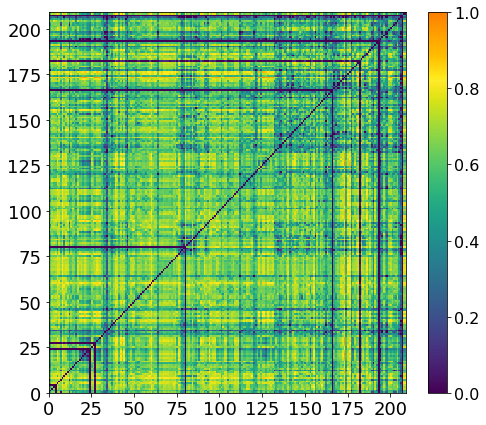

In [ ]:
# Scores distribuition histogram
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111)
dist_mat = squareform(unlab.ravel())
N = dist_mat.shape[0]

top = cm.get_cmap('viridis', 512)
bottom = cm.get_cmap('Wistia', 512)

newcolors = np.vstack((top(np.linspace(0, 1, 812)),
                       bottom(np.linspace(0.2, 1, 180))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

plt.pcolormesh(dist_mat, cmap=  newcmp)

cbar = plt.colorbar(ax=ax)
plt.clim(0,1) 
cbar.ax.tick_params(labelsize=16) 
plt.xlim([0,N])
plt.ylim([0,N])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
#plt.savefig('/content/drive/My Drive/cocrystal_design/figures/deep_scores_ heatmap.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

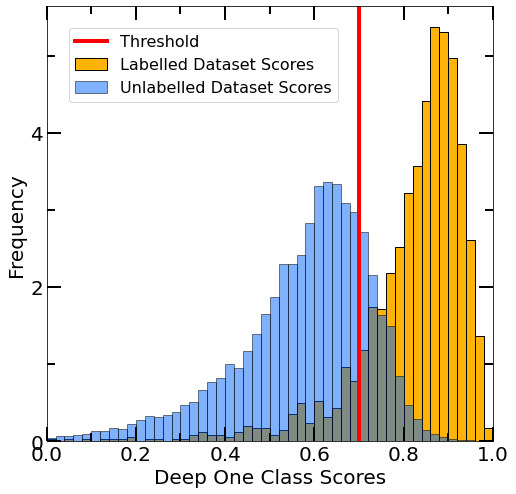

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')

_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.7, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
major_ticks_y = np.arange(0, 6, 2)
minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/My Drive/cocrystal_design/figures/deep_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
# Save the predictions for the pyrene possible pairs
pyr = np.concatenate([dictionary[dictionary.smiles1 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb, dictionary[dictionary.smiles2 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb])
pyra= unlab_final[unlab_final.Identifier.isin(pyr)]
pyr_dict=[]
for i in pyra.Identifier:
  pyr_dict.append(dict1[i])
pyrene_pairs = pd.concat([pd.DataFrame(pyr_dict, columns=['smiles1', 'smiles2']), pd.DataFrame(pyra.test_score.values, columns=['score'])], axis=1)
pyrene_pairs#.to_csv('/content/drive/My Drive/cocrystal_design/data/pyrene_pairs_scores_final.csv', index= False)

,smiles1,smiles2,score
0,O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34,c1cc2ccc3cccc4ccc(c1)c2c34,0.716076
1,c1cc2c3cccc4ccc5ccc(c1)c2c5c34,c1cc2ccc3cccc4ccc(c1)c2c34,0.647475
2,c1ccc2c(c1)c3cccc4ccc5cccc2c5c34,c1cc2ccc3cccc4ccc(c1)c2c34,0.790198
3,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,c1cc2ccc3cccc4ccc(c1)c2c34,0.785059
4,c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27,c1cc2ccc3cccc4ccc(c1)c2c34,0.800390
...,...,...,...
203,c1cc2ccc3cccc4ccc(c1)c2c34,CC(=C)C(=O)OCc1c2ccccc2cc3ccccc13,0.768345
204,c1cc2ccc3cccc4ccc(c1)c2c34,CN(C)c1ccc2nc3c(ccc4ccccc34)[o+]c2c1,0.593075
205,c1cc2ccc3cccc4ccc(c1)c2c34,Clc1cc2ccccc2nn1,0.348746
206,c1cc2ccc3cccc4ccc(c1)c2c34,c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51,-2.083835


#Visualize the results

The RDkit library is installed for enabling the visualizations. The molecules are visualized in pairs, e.g the firt two molecules compose the first co-crystal pair. The printed lists are separated into categories, according to the following criteria:\
1) No constrains\
2) Pairs after removing the solvents\
3) Pairs including one of the initial PAHs\
4) Pairs without solvents and heteroatoms\
5) Pairs including heteroatoms\
6) Pairs including 1,6 dicyanoanthracene, the most similar (Tanimoto Similarity) molecule to TCNQ (well known for the electronic properties)\
7) Pyrene-cocrystals (Pyrene was the most predicted co-former) 

In [ ]:
# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-06-21 21:37:55--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-06-21 21:37:55--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
expected: 6e267728e74a7089e59c7d8c59d20e6b
     got: ebb76490dfe6ce63b1dec5392631d80d  -
Unpacking payload ...
Solving envi

In [ ]:
# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [ ]:
# List including the starting PAHs

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene 
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51']                #corannulene 

In [ ]:
threshold = pd.DataFrame(unlab_final.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = unlab_final.sort_values(by = ['test_score'], ascending=True)
top_scored = unlab_final[unlab_final['test_score'] > threshold]
top_scored = top_scored.sort_values(by='test_score', ascending=False)
len(top_scored)

5434

In [ ]:
top_scored = top_scored.drop_duplicates(subset='test_score')

In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs

k2 = top_scored.Identifier
v2= top_scored.test_score
score_dict= {key:value for key, value in zip(k2, v2)}


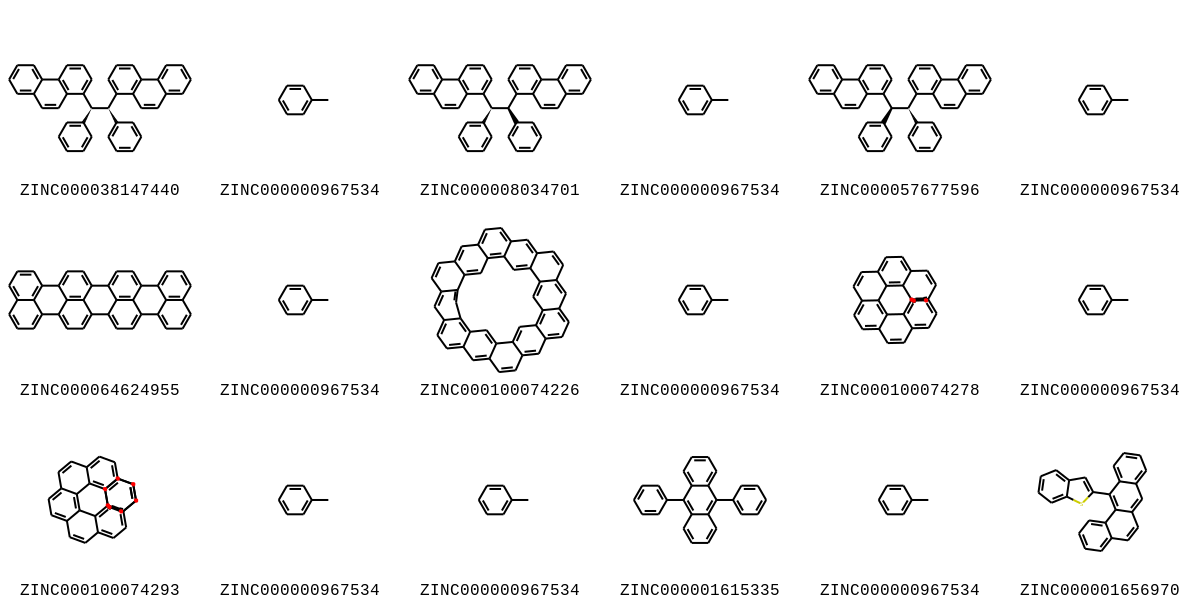

In [ ]:
# Print a list with the ranking with no constrains
lista=[]
score=[]

for i in top_scored.Identifier[:9]:
  lista.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(lista)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
Draw.IPythonConsole.drawOptions.legendFontSize = 16
Draw.IPythonConsole.drawOptions.atomLabelFontSize = 12
Draw.IPythonConsole.drawOptions.atomLabelMinFontSize = 70

IPythonConsole.molSize = (500,500)

subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6, subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_rank.png', "PNG")

In [ ]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1', 'Clc1ccccc1']
solvates=[]
for x in top_scored['Identifier']:
  if dict1[x][0] in solvents:
    solvates.append(x)
        
  if dict1[x][1] in solvents:
      solvates.append(x)

solvates = Remove(solvates)
len(solvates)
predictions = top_scored[~top_scored.Identifier.isin(solvates)]

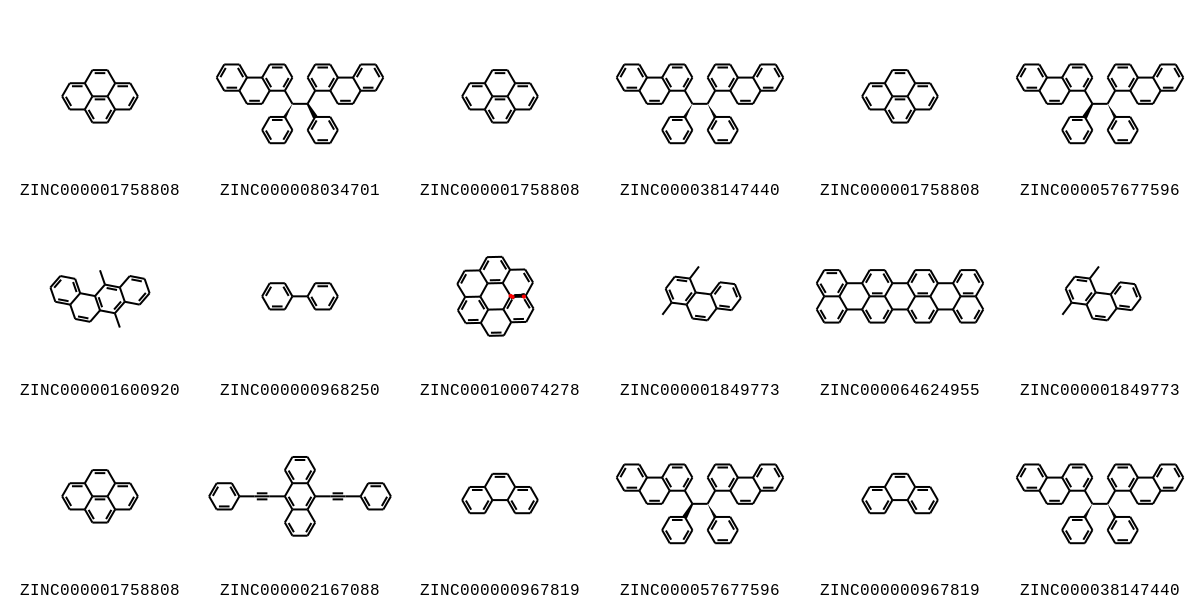

In [ ]:
# Print a list with the ranking after removing the solvents
listaki=[]
score=[]

for i in predictions.Identifier[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_rank_no_solvent.png', "PNG")

In [ ]:
# List with the combinations without heteroatoms
uf = pd.DataFrame(uf.values, columns=df.columns.values[1:])
het=pd.concat([uf_final.Identifier , uf['nHet'], uf['nHet.1']], axis=1)
het1 = het[het.nHet==0]
het2 =het1[het1['nHet.1']!=0]

het3 = het[het.nHet==0]
het4 =het1[het1['nHet.1']==0]
#no_het = [x for x in predictions.Identifier.values if x in het2.Identifier.values]

het = [x for x in predictions.Identifier.values if x not in het4.Identifier.values]

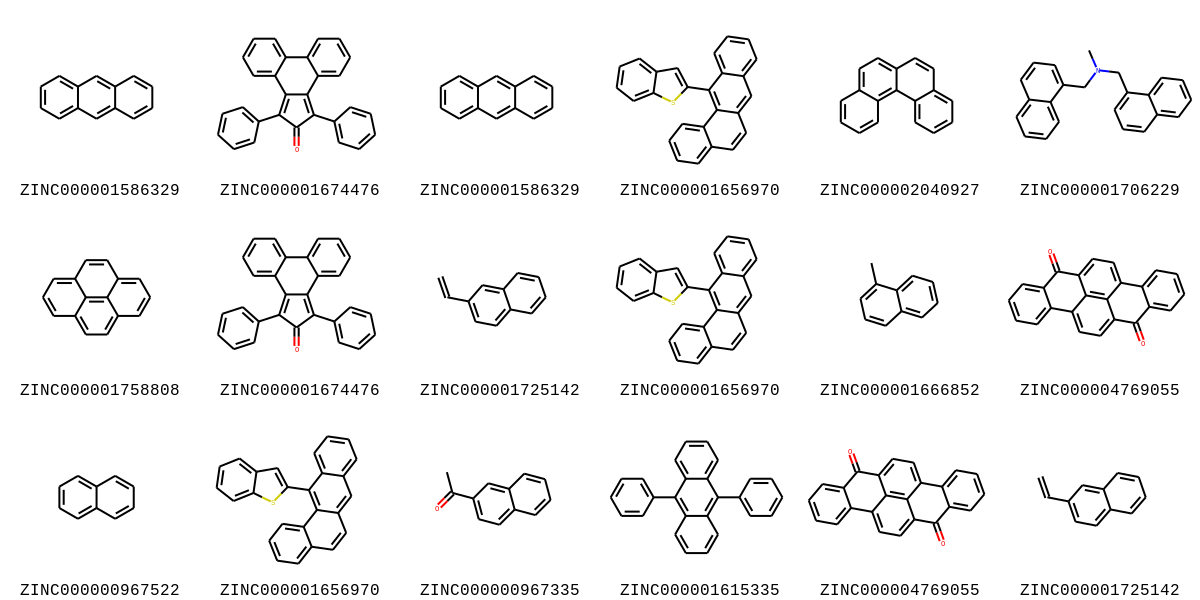

In [ ]:
# List_3: A list with the ranking with heteroatoms
listaki=[]
score=[]

for i in het[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_no_heteroatoms.png', "PNG")

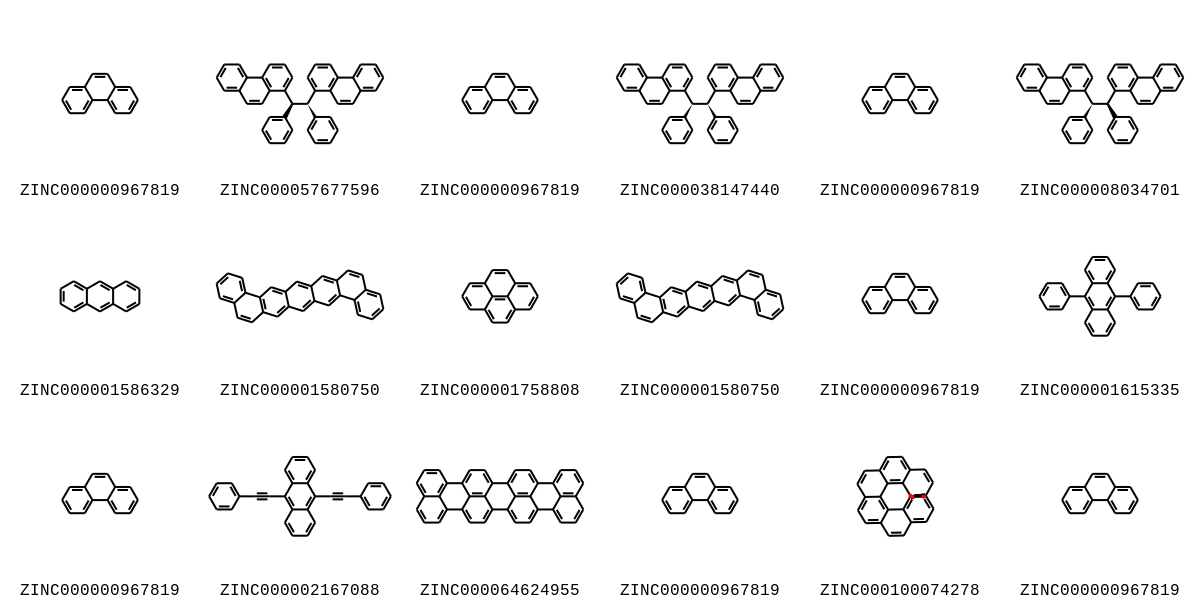

In [ ]:
# List4: Combinations including the starting PAHs
one=[]
for x in predictions['Identifier']:
  if dict1[x][0] in initial_molecules:
    one.append(x)
         
  else:
    if dict1[x][1] in initial_molecules:
      one.append(x)
one=Remove(one)
listaki=[]
score=[]

for i in one[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_initial_PAHs.png', "PNG")

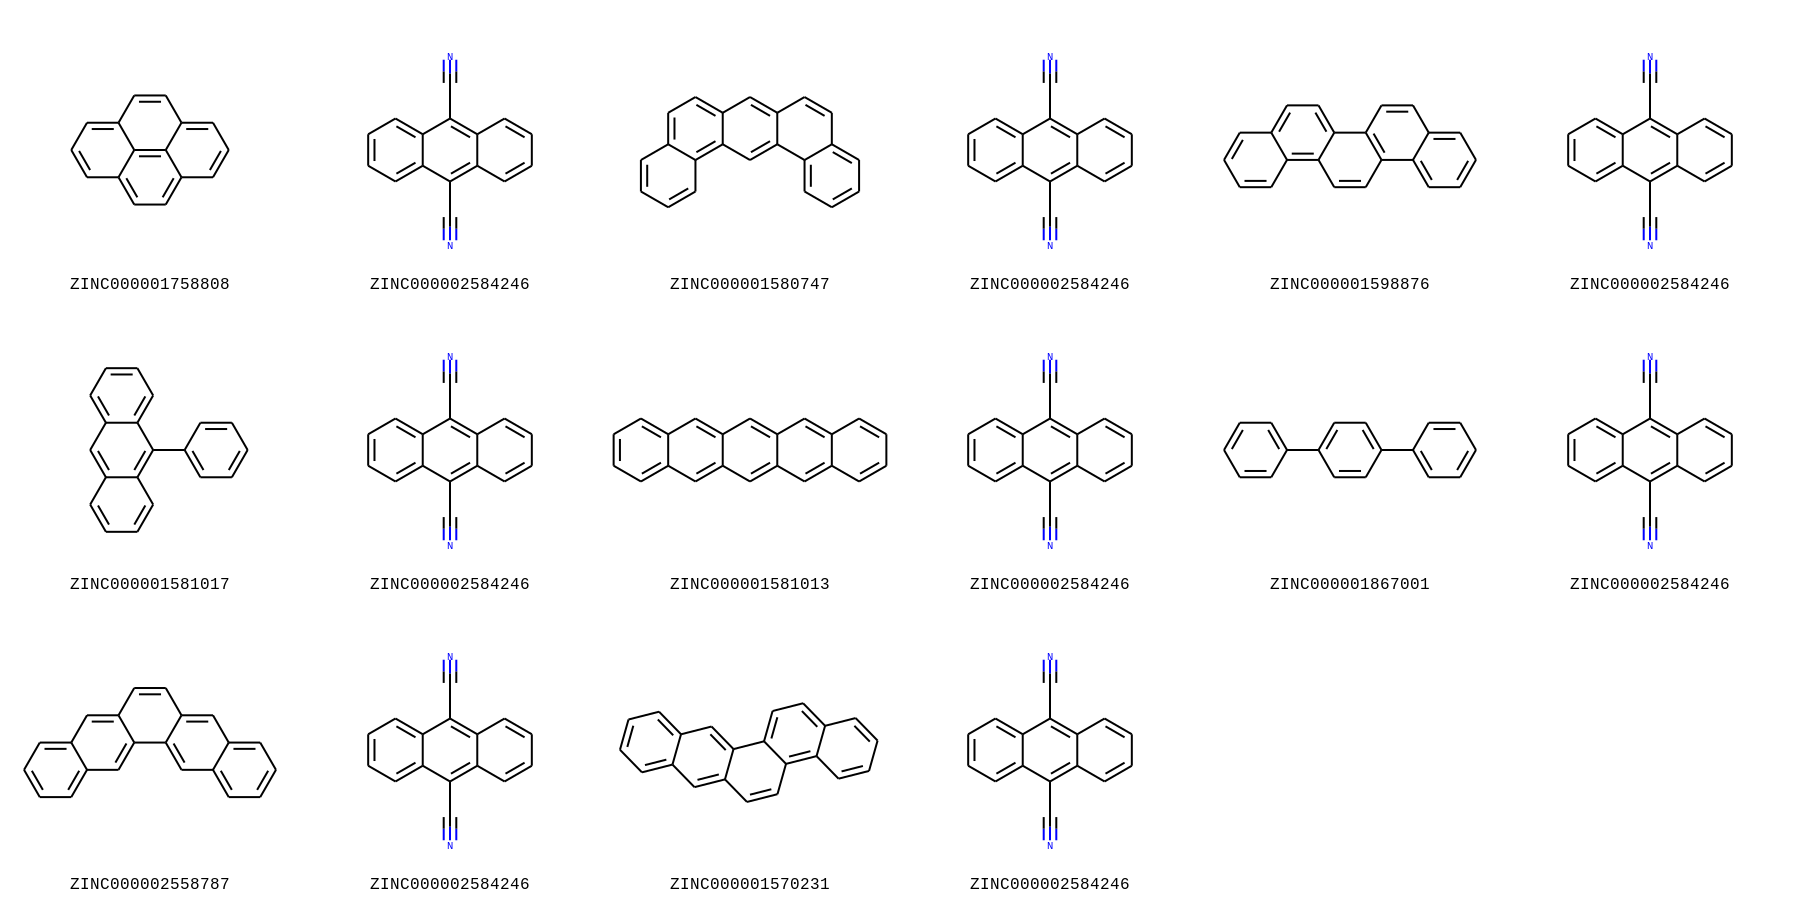

In [ ]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 
dicyano=[]
for x in predictions.Identifier:
  if dict1[x][0] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # if you want to check other molecules just change the two smiles here
    dicyano.append(x)        
  if dict1[x][1] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # and here
    dicyano.append(x)

dicyano= Remove(dicyano)    

listaki=[]
score=[]

for i in dicyano[:9]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
#IPythonConsole.molSize = (500,500)

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]



img=Draw.MolsToGridImage(subms,molsPerRow=6,legends=[zinc_dict[x] for x in merged], subImgSize=(300,300))#, options=options)
#Draw.IPythonConsole.drawOptions.atomLabelFontSize = 600
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_dicyano.svg', "PNG")



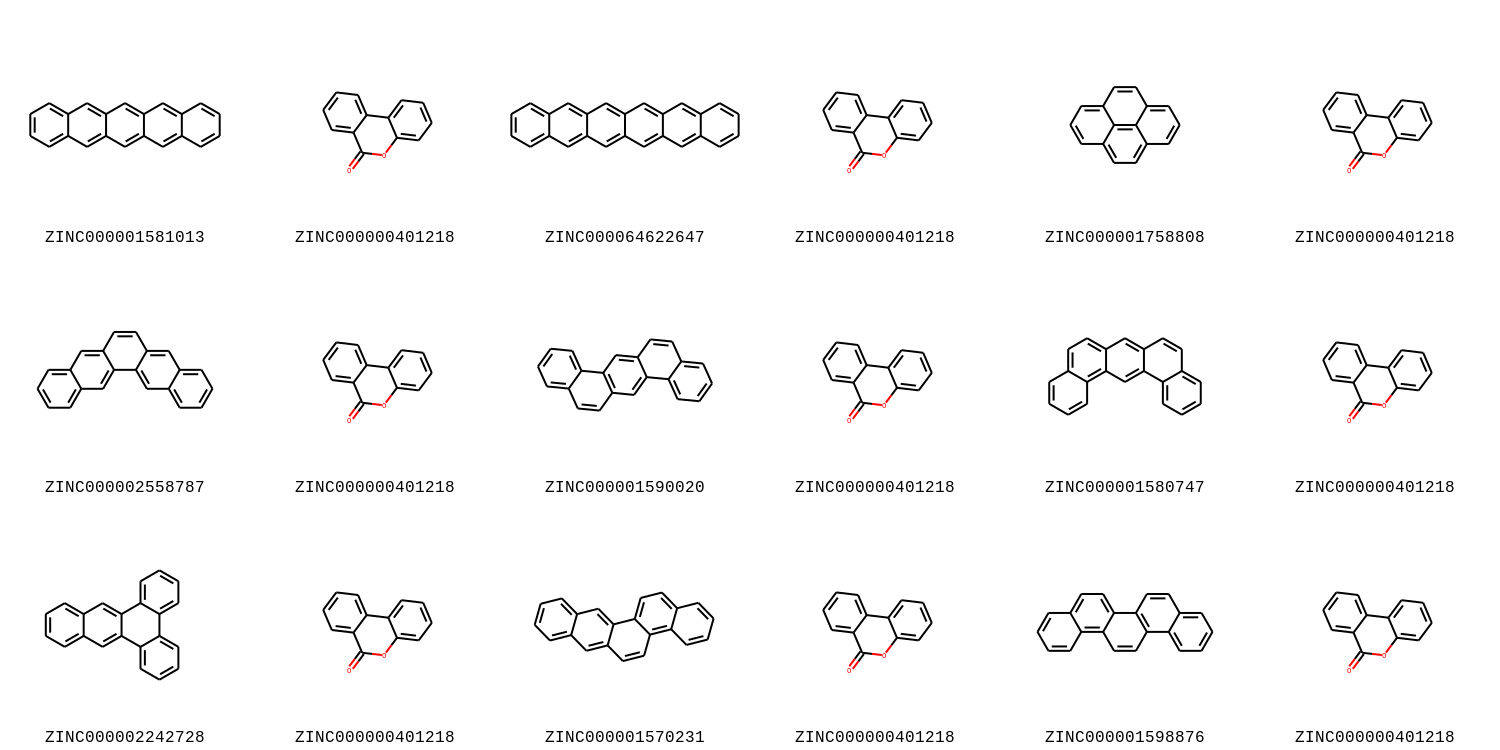

In [ ]:
mol2=[]
for x in predictions.Identifier:
  if dict1[x][0] == 'O=C1Oc2ccccc2c3ccccc13':     # if you want to check other molecules just change the two smiles here
    mol2.append(x)        
  if dict1[x][1] == 'O=C1Oc2ccccc2c3ccccc13':     # and here
    mol2.append(x)

mol2 = Remove(mol2)    
listaki=[]
score=[]

for i in mol2[:9]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

Draw.DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]

img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(250,250),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_initial_benzochromenone.png', "PNG")

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


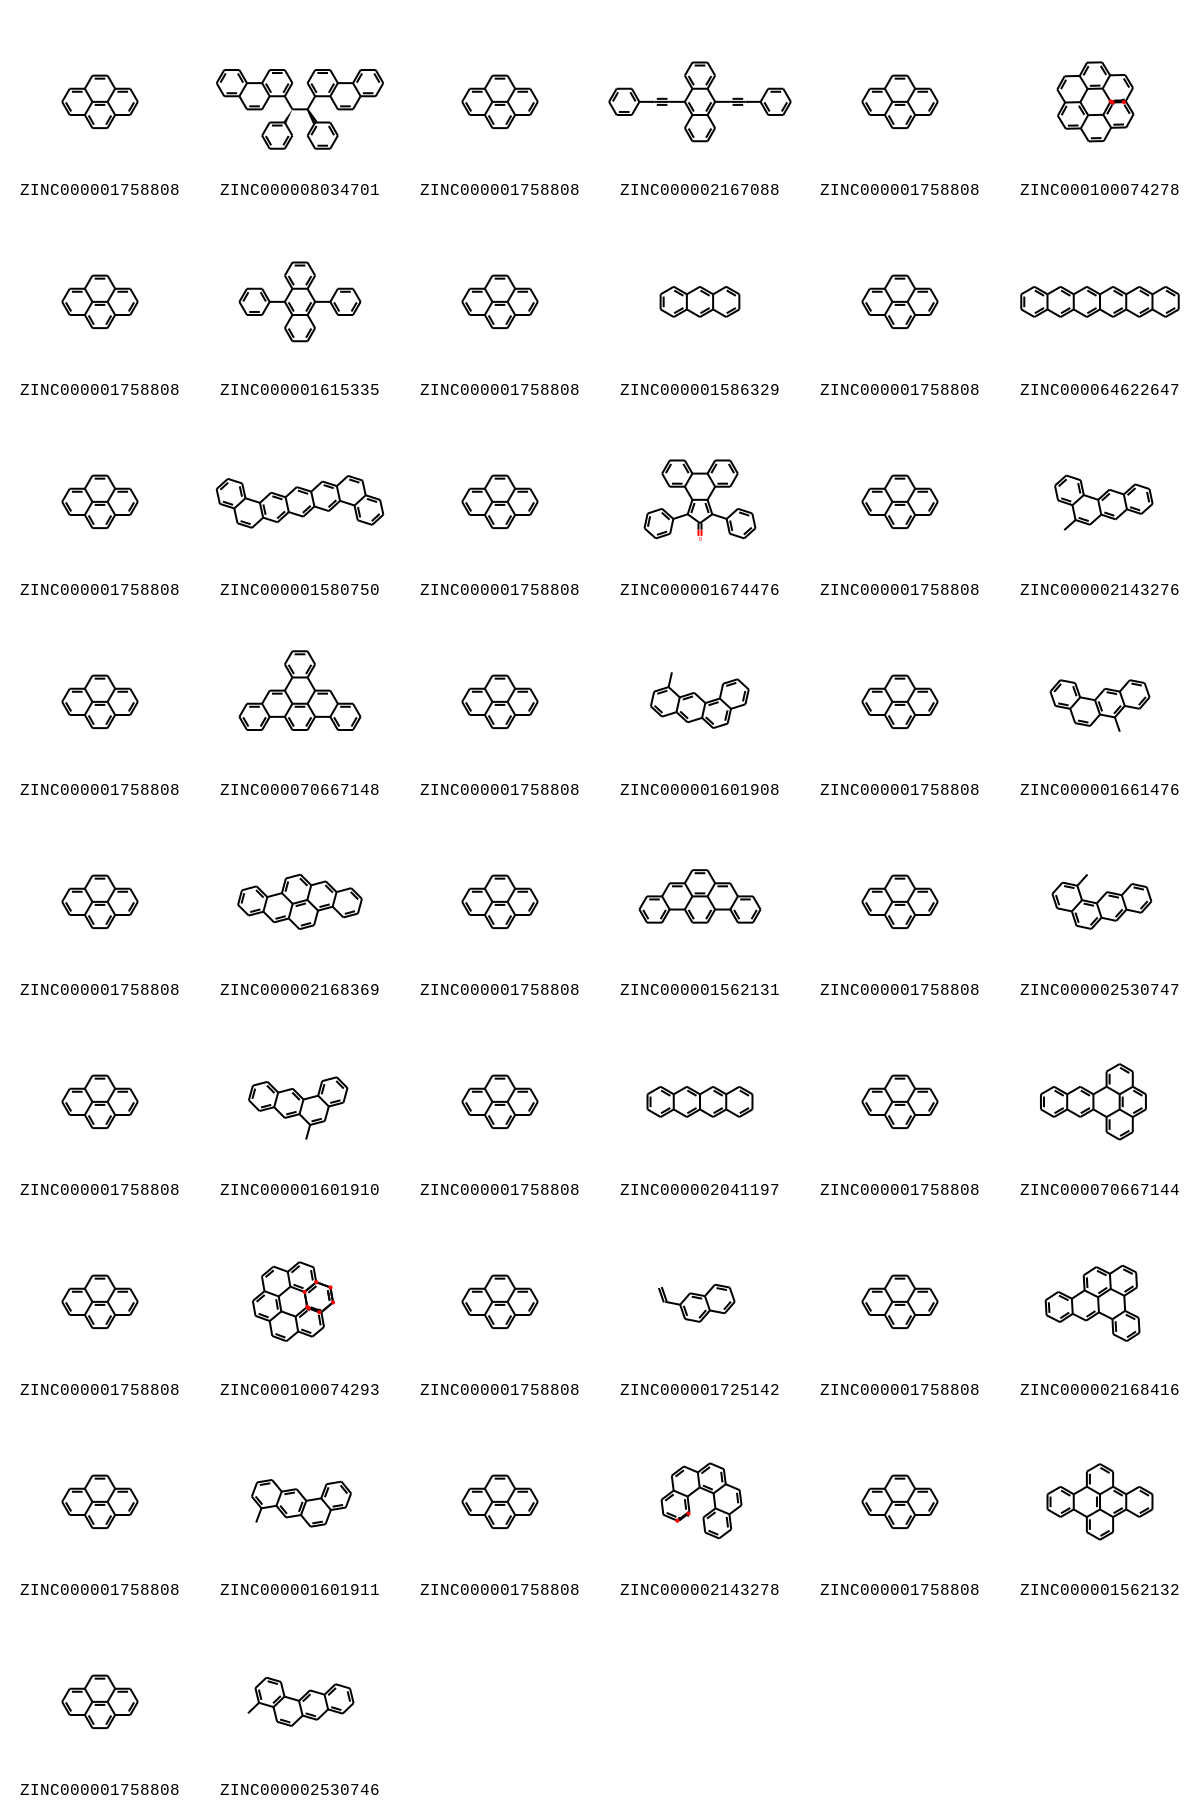

In [ ]:
# Show all the combinatios with pyrene
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

options = DrawingOptions()
options.legendFontSize = 18

pyrene=[]

for x in predictions.Identifier:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)

pyrene= Remove(pyrene)    

listaki=[]
pyrene_score=[]


for i in pyrene[:]:                      # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i]) # predictions[predictions.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200), legends=[zinc_dict[x] for x in merged] )
pyrene_img#.save('/content/drive/My Drive/cocrystal_design/figures/deep_pyrene.png', "PNG")

In [ ]:
predictions = list(top_scored['Identifier'])
listaki=[]
for i in predictions[:]:
  listaki.append(dict1[i])

In [ ]:
# Count the popularity
data1 = pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]])
data1 = [x for x in data1.values if x not in solvents]

data1= pd.DataFrame(data1, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:10]

dat1

,a
c1cc2ccc3cccc4ccc(c1)c2c34,148
c1ccc2cc3ccccc3cc2c1,146
c1ccc2c(c1)ccc3ccccc23,136
c1ccc2c(c1)ccc3ccc4ccccc4c23,125
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,122
c1ccc2ccccc2c1,120
Cc1cccc2c1ccc3ccccc23,116
C1=Cc2cccc3cccc1c23,115
C=Cc1ccc2ccccc2c1,115
c1ccc2cc3cc4ccccc4cc3cc2c1,114


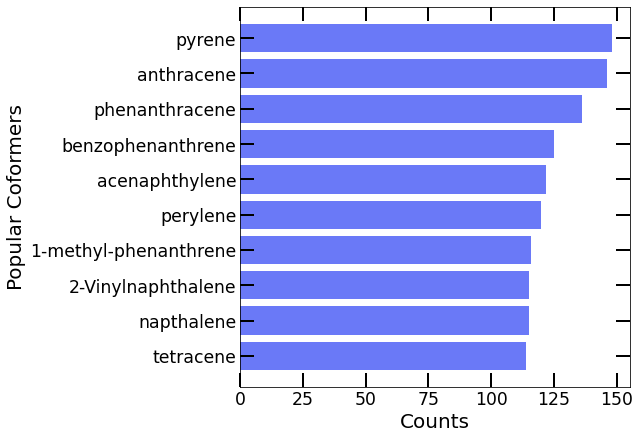

In [ ]:
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7,7))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')



x = ['pyrene', 'anthracene',
       'phenanthracene', 'benzophenanthrene',
       'acenaphthylene', 'perylene',
       '1-methyl-phenanthrene', '2-Vinylnaphthalene', 'napthalene',
       'tetracene']

#['c1cc2ccc3cccc4ccc(c1)c2c34 (pyrene)', 'c1ccc2cc3ccccc3cc2c1 (anthracene)',
 #      'c1ccc2c(c1)ccc3ccccc23(phenanthracene)', 'c1ccc2c(c1)ccc3ccc4ccccc4c23 (benzophenanthrene)',
  #     'C1=Cc2cccc3cccc1c23 (  acenaphthylene)', 'c1cc2cccc3c4cccc5cccc(c(c1)c23)c45 (perylene)',
   #    'Cc1cccc2c1ccc3ccccc23 (1-methyl-phenanthrene)', 'C=Cc1ccc2ccccc2c1 (2-Vinylnaphthalene)', 'c1ccc2ccccc2c1 (napthalene)',
    #   'c1ccc2cc3cc4ccccc4cc3cc2c1 (tetracene)']
#dat1.index
energy = dat1.a
x_pos = [i for i, _ in enumerate(x)]

idx = np.asarray([i for i in range(len(x))])                 
#ax.set_yticks(idx)
#ax.yaxis.set_label_position("left")
#ax.yaxis.tick_right()

plt.barh(x_pos, energy, color='#6a79f7')
plt.gca().invert_yaxis()
plt.ylabel("Popular Coformers",fontsize=20, fontweight='normal')
plt.xlabel("Counts" ,fontsize=20,  fontweight='normal')

plt.yticks(x_pos, x)
#plt.savefig('bar_pop.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

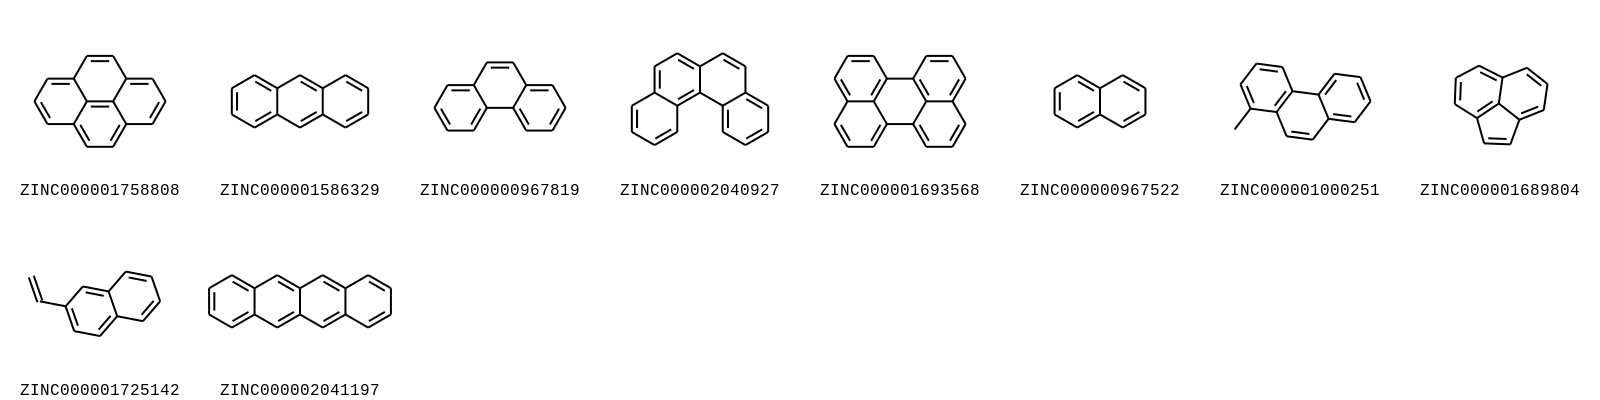

In [ ]:
# Visualize the popular co-formers
smi= dat1.index 
subms1 = [Chem.MolFromSmiles(x) for x in smi]


img=Draw.MolsToGridImage(subms1,molsPerRow=8,subImgSize=(200,200), legends=[zinc_dict[x] for x in smi])
img   

In [ ]:
pyrene=[]
for x in predictions[:]:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # if you want to check other molecules just change the two smiles here
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # and here
    pyrene.append(x)

pyrene= Remove(pyrene)    
listaki2=[]
score=[]

for i in pyrene[:]:       # select the number of the predictions you want to see
  score.append(score_dict[i])
  listaki2.append(dict1[i])
   
ar=np.array(listaki2)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=2 ,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])

Number of combinations: 150


/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


In [ ]:
df_pyrene  = pd.concat([pd.DataFrame(pyrene, columns=['combination_id']), 
                       pd.DataFrame(pyrene_score, columns=['score'])], axis=1) #  pd.DataFrame(zinc_id, columns=['zinc_id1']), pd.DataFrame(zinc_id2, columns=['zinc_id2']), 
df_pyrene


,combination_id,score
0,comb1754,0.867815
1,comb1816,0.858400
2,comb1656,0.854286
3,comb1809,0.851284
4,comb1688,0.849585
...,...,...
138,comb1705,0.699909
139,comb1775,0.697557
140,comb1781,0.695837
141,comb1640,0.688774


In [ ]:
# Set the HTML table properties
td_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('border', '1px solid black')
  ]

th_props = [
  ('font-size', '18px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#b6ffbb'),
  ('border', '10px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

In [ ]:
num_of_comb= len(pyrene)
listaki_2 = []
for i in range(num_of_comb):
    y = i * 200
    listaki_2.append(pyrene_img.crop((0, y, 400, y + 200)))

,combination_id,score,molecular pairs
0,comb1754,0.867815,
1,comb1816,0.858400,
2,comb1656,0.854286,
3,comb1809,0.851284,
4,comb1688,0.849585,

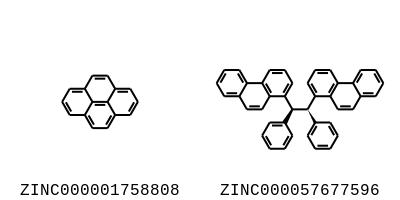
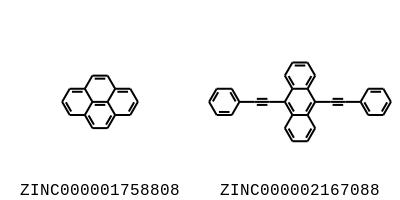
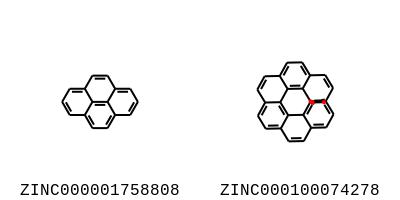
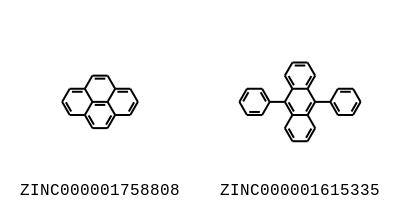
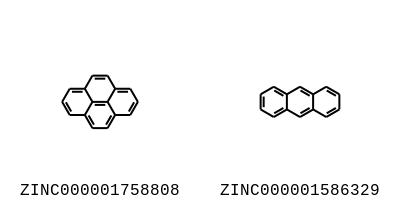

In [ ]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
images = listaki_2
df_pyrene['molecular pairs'] = images

# convert your links to html tags 
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

html = (df_pyrene.iloc[:,:].head().style
               .set_table_styles(styles)
               .format({'molecular pairs': image_formatter})
               .render())
HTML(html)